In [40]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# use base python(3.9.12)  
# Nvidia 5 year historical data
endpoint_url = "https://financialmodelingprep.com/api/v3/historical-price-full/NVDA?apikey=wc2bbHWhFBL7no45kaUlx2xLHI2z2wv1"

# Fetch data from the endpoint
response = requests.get(endpoint_url)
data = response.json()

# Check if data is fetched successfully
if "historical" in data:
    # Convert data to DataFrame
    df = pd.DataFrame(data["historical"])
    
    
    print("Data for "+data["symbol"]+" For Last 5 years")


    
    # calculate latest Volume  
    latest_volume = df.iloc[0]['volume']
    print("Latest Volume:", latest_volume)

    # Change percentage each year 

    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    yearly_changes = df.groupby('year').agg({'close': lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100})
    print("Yearly Change Percentage:")
    print(yearly_changes)

    # Change over last 5 years 

    change_over_5_years = (df.iloc[-1]['close'] - df.iloc[0]['close']) / df.iloc[0]['close'] * 100
    print("Change over last 5 years:", change_over_5_years)

    # data analysis / visualization 
    

else:
    print("Failed to fetch data from the API endpoint.")


Data for NVDA For Last 5 years
Latest Volume: 43129744
Yearly Change Percentage:
           close
year            
2019  -22.539521
2020  -54.055917
2021  -55.411241
2022  106.110579
2023  -71.093655
2024  -46.690867
Change over last 5 years: -94.95661605206072


## Libraries

In [19]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

## Fetching Data

In [3]:
endpoint_url = "https://financialmodelingprep.com/api/v3/historical-price-full/NVDA?apikey=wc2bbHWhFBL7no45kaUlx2xLHI2z2wv1"
response = requests.get(endpoint_url)
data = response.json()

## data preprocessing


In [4]:
if "historical" in data:
    # Convert data to DataFrame
    df = pd.DataFrame(data["historical"])
    
    # Preprocessing
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
else:
    print("Failed to fetch data from the API endpoint.")

## Feature selection



In [5]:

features = ['open', 'high', 'low', 'close', 'volume']
df = df[features]

## Training (70%) and Testing (30%) 

In [6]:
train_size = int(len(df) * 0.7)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

## Normalizing 

In [7]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

## Time series Dataset

In [11]:
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

## Number of cycles

In [12]:
time_steps = 10

## Creating Training and Testing dataset

In [13]:
X_train, y_train = create_dataset(train_scaled, train_scaled[:, 3], time_steps)
X_test, y_test = create_dataset(test_scaled, test_scaled[:, 3], time_steps)

## Building LSTM Model

In [14]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

c:\Users\mabro\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Training the model 

In [24]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.0732e-04 - val_loss: 4.1141e-05
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - val_loss: 2.6853e-05
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.5260e-04 - val_loss: 3.1859e-05
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3297e-04 - val_loss: 2.0846e-05
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2676e-04 - val_loss: 2.4771e-05
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3316e-04 - val_loss: 2.3427e-05
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2109e-04 - val_loss: 2.4021e-05
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1643e-04 - val_loss: 2.3539e-05
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1171e-04 - val_loss: 2.3525e-05
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0895e-04 - val_loss: 2.3406e-05
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.0557e-04 - val_los

## Training and Validation loss

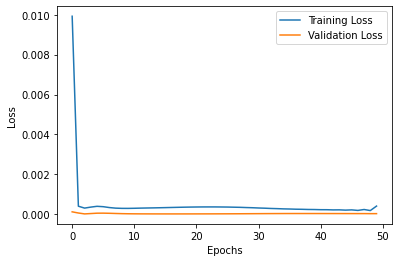

In [20]:
# plotting 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# Make predictions on the test data
y_pred = model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


# Prediction vs Actual

In [46]:



y_pred = y_pred.reshape(-1, 1)

print("Shape of y_pred:", y_pred.shape)



# Inverse transform the predicted values and actual values if scaled
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

print("Shape of y_test_inv:", y_test_inv.shape)



plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
plt.show()

ValueError: non-broadcastable output operand with shape (368,1) doesn't match the broadcast shape (368,5)